In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import statsmodels.api as sm

import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('default')

import seaborn as sns
sns.set_theme(style="ticks")

#fred data
from fredapi import Fred
fred = Fred(api_key='1bb785afd4dae7403f57b2a5f667cecc')

In [2]:
all_items = pd.read_pickle('../../datastore/processed_data/not_seasonally_adjusted/1. All Items.pickle')[12:] #remove first 12 na values from pct change calc
all_items

,series_title,value,yoy_inflation_rate,mom_inflation_rate
date,,,,
1914-01-31,"All items in U.S. city average, all urban cons...",10.000,0.020408,0.000000
1914-02-28,"All items in U.S. city average, all urban cons...",9.900,0.010204,-0.010000
1914-03-31,"All items in U.S. city average, all urban cons...",9.900,0.010204,0.000000
1914-04-30,"All items in U.S. city average, all urban cons...",9.800,0.000000,-0.010101
1914-05-31,"All items in U.S. city average, all urban cons...",9.900,0.020619,0.010204
...,...,...,...,...
2021-10-31,"All items in U.S. city average, all urban cons...",276.589,0.062219,0.008308
2021-11-30,"All items in U.S. city average, all urban cons...",277.948,0.068090,0.004913
2021-12-31,"All items in U.S. city average, all urban cons...",278.802,0.070364,0.003073


In [3]:
#importing other items for charting
food = pd.read_pickle('../../datastore/processed_data/not_seasonally_adjusted/1.1 Food.pickle')[12:] #remove first 12 na values from pct change calc
energy = pd.read_pickle('../../datastore/processed_data/not_seasonally_adjusted/1.2 Energy.pickle')[12:] #remove first 12 na values from pct change calc
commodities_less_food_and_energy = pd.read_pickle('../../datastore/processed_data/not_seasonally_adjusted/1.3.1 Commodities less food and energy commodities.pickle')[12:] #remove first 12 na values from pct change calc
services_less_energy_services = pd.read_pickle('../../datastore/processed_data/not_seasonally_adjusted/1.3.2 Services less energy services.pickle')[12:] #remove first 12 na values from pct change calc


In [4]:
inflation_time_series = all_items.copy()

In [5]:
#recession data
recession_indicator = fred.get_series('USRECM')
recession_indicator = recession_indicator.resample('M').last()
recession_indicator.name = 'recession_indicator'
recession_indicator = recession_indicator[recession_indicator.index >= inflation_time_series.index.min()] #only go back as far as we need.

recession_dates = recession_indicator[recession_indicator == 1].index


unemployment_rate = fred.get_series('UNRATE')
unemployment_rate = unemployment_rate.resample('M').last()
unemployment_rate.name = 'unemployment_rate'
unemployment_rate = unemployment_rate[unemployment_rate.index >= inflation_time_series.index.min()] #only go back as far as we need.

stock_market_rolling_monthly_return = fred.get_series('WILL5000INDFC')
stock_market_rolling_monthly_return = stock_market_rolling_monthly_return.resample('M').last()
stock_market_rolling_monthly_return = stock_market_rolling_monthly_return.pct_change()
stock_market_rolling_monthly_return.name = 'stock_market_rolling_monthly_return'
stock_market_rolling_monthly_return = stock_market_rolling_monthly_return[stock_market_rolling_monthly_return.index >= inflation_time_series.index.min()] #only go back as far as we need.


stock_market_rolling_12_month_return = fred.get_series('WILL5000INDFC')
stock_market_rolling_12_month_return = stock_market_rolling_12_month_return.resample('M').last()
stock_market_rolling_12_month_return = stock_market_rolling_12_month_return.pct_change(12)[12:]
stock_market_rolling_12_month_return.name = 'stock_market_rolling_12_month_return'
stock_market_rolling_12_month_return = stock_market_rolling_12_month_return[stock_market_rolling_12_month_return.index >= inflation_time_series.index.min()] #only go back as far as we need.

m_two_money_supply_monthly_change = fred.get_series('M2SL')
m_two_money_supply_monthly_change = m_two_money_supply_monthly_change.resample('M').last()
m_two_money_supply_monthly_change = m_two_money_supply_monthly_change.pct_change(1)[1:]
m_two_money_supply_monthly_change.name = 'm_two_money_supply_monthly_change'
m_two_money_supply_monthly_change = m_two_money_supply_monthly_change[m_two_money_supply_monthly_change.index >= inflation_time_series.index.min()] #only go back as far as we need.


m_two_money_supply_twelve_month_change = fred.get_series('M2SL')
m_two_money_supply_twelve_month_change = m_two_money_supply_twelve_month_change.resample('M').last()
m_two_money_supply_twelve_month_change = m_two_money_supply_twelve_month_change.pct_change(12)[12:]
m_two_money_supply_twelve_month_change.name = 'm_two_money_supply_twelve_month_change'
m_two_money_supply_twelve_month_change = m_two_money_supply_twelve_month_change[m_two_money_supply_twelve_month_change.index >= inflation_time_series.index.min()] #only go back as far as we need.


#https://fred.stlouisfed.org/graph/?g=f1cZ
output_gap = 100* (fred.get_series('GDPPOT') / fred.get_series('GDPC1'))
output_gap = output_gap.resample('M').last()
output_gap.name = 'output_gap'
output_gap = output_gap[output_gap.index >= inflation_time_series.index.min()] #only go back as far as we need.


fed_funds = fred.get_series('FEDFUNDS')
fed_funds = fed_funds.resample('M').last()
fed_funds.name = 'fed_funds'
fed_funds = fed_funds[fed_funds.index >= inflation_time_series.index.min()] #only go back as far as we need.



ten_year = fred.get_series('DGS10')
ten_year = ten_year.resample('M').last()
ten_year.name = 'ten_year'
ten_year = ten_year[ten_year.index >= inflation_time_series.index.min()] #only go back as far as we need.



# GDP pct change
gdp_twelve_month_change = fred.get_series('GDPC1')
gdp_twelve_month_change = gdp_twelve_month_change.resample('M').last().ffill()
gdp_twelve_month_change = gdp_twelve_month_change.pct_change(12)[12:]
gdp_twelve_month_change.name = 'gdp_twelve_month_change'
gdp_twelve_month_change = gdp_twelve_month_change[gdp_twelve_month_change.index >= inflation_time_series.index.min()] #only go back as far as we need.

# GDP
gdp = fred.get_series('GDPC1')
gdp = gdp.resample('M').last().ffill()
gdp.name = 'gdp'
gdp = gdp[gdp.index >= inflation_time_series.index.min()] #only go back as far as we need.




In [6]:
#aggregate timeseries together.
aggregated_data = pd.concat([
    inflation_time_series, 
    recession_indicator,
    unemployment_rate,
    stock_market_rolling_12_month_return,
    stock_market_rolling_monthly_return,
    m_two_money_supply_monthly_change,
    m_two_money_supply_twelve_month_change,
    output_gap,
    fed_funds,
    ten_year,
    gdp_twelve_month_change,
    gdp
], axis=1)
aggregated_data

aggregated_data = aggregated_data[aggregated_data.index < '3/1/2022']
aggregated_data['equity_returns_positive'] = aggregated_data['stock_market_rolling_12_month_return'] > 0

Text(0, 0.5, 'Year over Year Inflation Rate (%)')

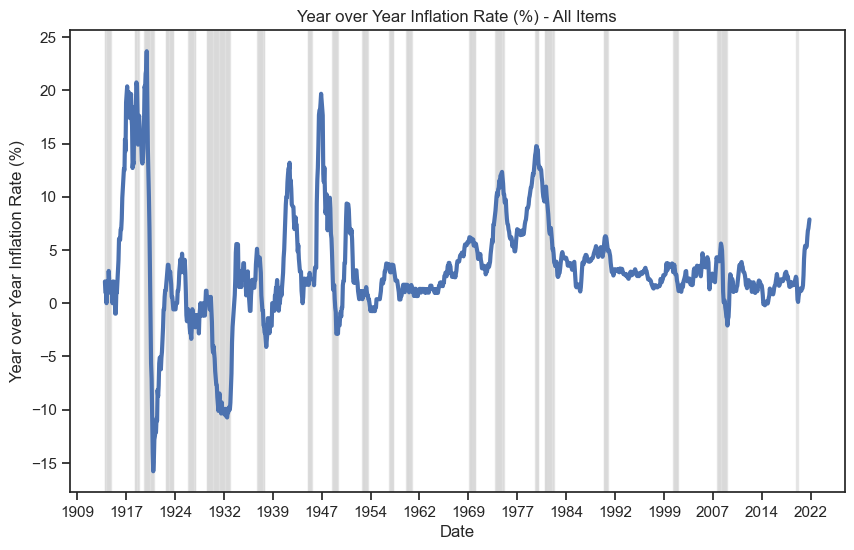

In [7]:
# Plot All Items
#create fig and subplots structure.
fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize= (10,6))

ax1.plot(aggregated_data.yoy_inflation_rate * 100, label='All Items', linewidth=3)

for day in recession_dates:
    ax1.axvspan(day, day + datetime.timedelta(days=1), color="#D3D3D3", alpha=0.5)
        
#     #format date xaxis and set.
months = mdates.MonthLocator(interval=90, bymonthday=-1)
months_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(months_fmt)

#set title, xaxis and yaxis labels.
ax1.set_title("Year over Year Inflation Rate (%) - All Items")
ax1.set_xlabel('Date') 
ax1.set_ylabel('Year over Year Inflation Rate (%)') 


Text(0, 0.5, 'Ferquency (%)')

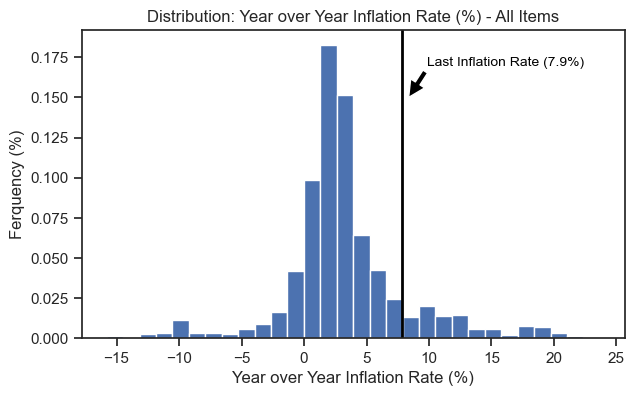

In [8]:
# Histogram How big of a move

#create fig and subplots structure.
fig, (ax1) = plt.subplots(1, 1, figsize= (7,4))

ax1.hist(aggregated_data.yoy_inflation_rate * 100, label='All Items', bins=30, density=True)

last_inflation_rate = aggregated_data.yoy_inflation_rate[-1] * 100
ax1.axvline(last_inflation_rate ,linewidth=2, color='black')

plt.annotate(f'Last Inflation Rate ({last_inflation_rate.round(1)}%)', xy = (last_inflation_rate + .5, .15), 
             fontsize = 10, xytext = (last_inflation_rate + 2, .17), 
             arrowprops = dict(facecolor = 'black'),
             color = 'black')

#set title, xaxis and yaxis labels.
ax1.set_title("Distribution: Year over Year Inflation Rate (%) - All Items")
ax1.set_xlabel('Year over Year Inflation Rate (%)') 
ax1.set_ylabel('Ferquency (%)') 

In [15]:
stats_we_care_about = ['Last Inflation Rate', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Last Inflation Rate Z-Score', ]

data_described = (aggregated_data.describe()* 100)[['yoy_inflation_rate']]
data_described = data_described.T 
data_described['Last Inflation Rate'] = aggregated_data['yoy_inflation_rate'][-1] * 100
data_described['Last Inflation Rate Z-Score'] = (aggregated_data['yoy_inflation_rate'][-1] - aggregated_data['yoy_inflation_rate'].mean()) / aggregated_data['yoy_inflation_rate'].std()
data_described = data_described.T
data_described = data_described[data_described.index.isin(stats_we_care_about)].round(1)

In [16]:
data_described_after_1997 = (aggregated_data[aggregated_data.index > '01/01/1997'].describe()* 100)[['yoy_inflation_rate']]

data_described_after_1997 = data_described_after_1997.T 
data_described_after_1997['Last Inflation Rate'] = aggregated_data['yoy_inflation_rate'][-1] * 100
data_described_after_1997['Last Inflation Rate Z-Score'] = (aggregated_data[aggregated_data.index > '01/01/1997']['yoy_inflation_rate'][-1] - aggregated_data[aggregated_data.index > '01/01/1997']['yoy_inflation_rate'].mean()) / aggregated_data[aggregated_data.index > '01/01/1997']['yoy_inflation_rate'].std()
data_described_after_1997 = data_described_after_1997.T
data_described_after_1997 = data_described_after_1997[data_described_after_1997.index.isin(stats_we_care_about)].round(1)

In [18]:
data_described_combined = pd.concat([data_described, data_described_after_1997], axis=1)
data_described_combined.columns = ['YoY Inflation Rate (1914-2022)', 'YoY Inflation Rate (1997-2022)' ]
data_described_combined

,YoY Inflation Rate (1914-2022),YoY Inflation Rate (1997-2022)
mean,3.2,2.3
std,5.0,1.4
min,-15.8,-2.1
25%,1.2,1.5
50%,2.6,2.1
75%,4.6,3.0
max,23.7,7.9
Last Inflation Rate,7.9,7.9
Last Inflation Rate Z-Score,0.9,4.1


                            OLS Regression Results                            
Dep. Variable:     yoy_inflation_rate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.666
Date:                Fri, 15 Apr 2022   Prob (F-statistic):              0.197
Time:                        08:17:57   Log-Likelihood:                -2197.2
No. Observations:                 886   AIC:                             4398.
Df Residuals:                     884   BIC:                             4408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Text(0, 0.5, 'Monthly over Month Inflation Rate (%)')

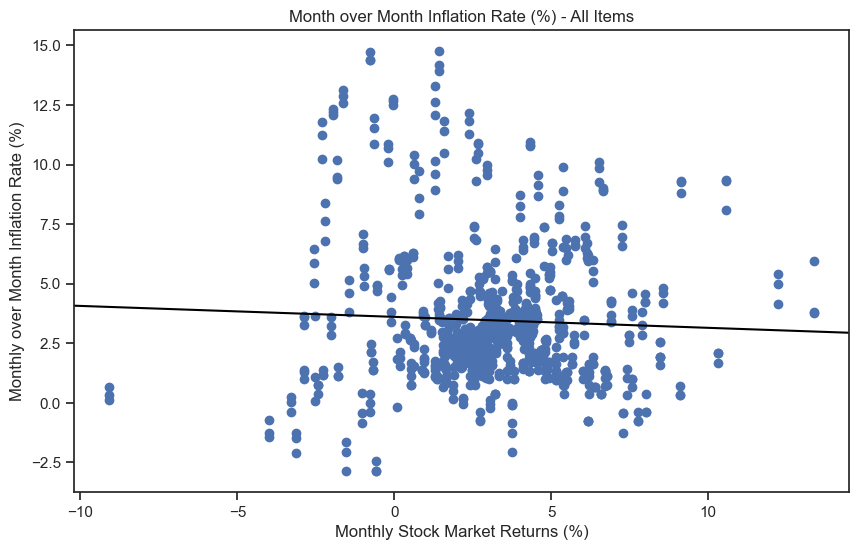

In [14]:
# Modeling CPI. This is not right.
#create fig and subplots structure.
from statsmodels.graphics.regressionplots import abline_plot

sub_data = aggregated_data#[(aggregated_data.index > '01/01/1970') & (aggregated_data.index < '01/01/1980')].dropna()
y = aggregated_data.yoy_inflation_rate * 100
x =aggregated_data.gdp_twelve_month_change * 100

X = sm.add_constant(x)

model = sm.OLS(y,X, missing='drop')
model_result = model.fit()
print(model_result.summary())


fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize= (10,6))

ax1.scatter(x=x, y=y)
ax1.scatter(x=x[-1], y=y[-1], label='Last Point')

#add regression line to plot
abline_plot(model_results=model.fit(), ax=ax1, color='black')


#set title, xaxis and yaxis labels.
ax1.set_title("Month over Month Inflation Rate (%) - All Items")
ax1.set_xlabel('Monthly Stock Market Returns (%)') 
ax1.set_ylabel('Monthly over Month Inflation Rate (%)') 
